In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import time
import pickle
from functools import reduce
from deap import creator, base, tools, algorithms, benchmarks, cma
import hashlib
from itertools import chain

%matplotlib inline
import matplotlib.pyplot as plt

/Users/chiselko6/anaconda/envs/iai/lib/python3.6/site-packages/deap/tools/_hypervolume/pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


In [2]:
INPUT_PATH = '../../2/limontov/input/'
np.random.seed(6)
storage = {}

In [3]:
def read_base(N, map_f=None):
    global storage
    dataset = storage.get(N)
    c_type = 'mapped' if map_f else 'raw'
    if dataset:
        if dataset.get(c_type):
            print('found cached data...')
            return dataset[c_type]
    else:
        storage[N] = dict()
    print('reading data from source...')
    LINES = 10**6
    path = '{}Base{}.txt'.format(INPUT_PATH, N)
    X, y = [], []
    with open(path, 'r') as fin:
        for l in tqdm(fin.readlines()):
            x = l.split()[0]
            if map_f:
                X.append(map_f(x))
            else:
                X.append(list(x))
            y.append(l.split()[1])
    print('converting to dataframe...')
    storage[N][c_type] = (pd.DataFrame(X, dtype=int), pd.Series(y, dtype=int))
    return storage[N][c_type]

In [4]:
def do_xor(x):
    cur_xor = 0
    res = []
    for i in x:
        cur_xor ^= int(i)
        res.append(cur_xor)
    return res

def do_hash(ch):
    return list(map(int, ''.join(np.array([format(x, 'b').rjust(8, '0').split() for x in bytearray(hashlib.sha256(ch.encode()).digest())]).flatten())))

In [5]:
def learn(X, y, model=None, N=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    if model is None:
        filename = '../../2/limontov/output/pickled_{}.pkl'.format(N)
        with open(filename, 'rb') as fin:
            model = pickle.load(fin)
    else:
        model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    score = model.score(X_test, y_test)
    print(score)
    return model, score

In [7]:
N = 16
X_orig, y_orig = read_base(N)
X_hashed, y_hashed = read_base(N, do_hash)

reading data from source...


100%|██████████| 1000000/1000000 [00:02<00:00, 340708.06it/s]


converting to dataframe...


  0%|          | 0/1000000 [00:00<?, ?it/s]

reading data from source...


100%|██████████| 1000000/1000000 [02:23<00:00, 6969.21it/s]


converting to dataframe...


In [13]:
orig_map = {}
for idx, x in enumerate(X_orig.values):
    orig_map[''.join(map(str, x))] = y_orig[idx]
    
def mask_to_hash(X):
    ts = X.agg(lambda x: ''.join(map(str, x)), axis='columns')
    y = ts.map(lambda v: orig_map.get(v[:N], -1))
    return X[y != -1], y[y != -1]

In [32]:
SCORES = []

In [33]:
def get_fitness(x):
    global SCORES
    model = LogisticRegression(n_jobs=-1, random_state=6)
    x = np.array(x)
    mask = np.sign(x)
    m = []
    fl = False
    print('Getting first {} valuable bits'.format(N))
    for idx, i in enumerate(mask):
        if i == 1:
            m.append(idx)
        if len(m) == N:
            break
    else:
        fl = True
    
    print('Generating final X')
    print('m', m)
    if fl:
        print('Bad concat')
        X_masked = pd.concat([X_hashed[m], pd.DataFrame(np.ones((X_hashed.shape[0], N - len(m))))], axis=1)
    else:
        print('Could find needed bits')
        X_masked = X_hashed[m]
    print('Mapping with hash')
    X_masked, y_masked = mask_to_hash(X_masked)
    print(X_masked.shape, y_masked.shape)
    print('Applying XOR')
    X_masked = X_masked.apply(do_xor, axis=0)
    print('Learning the model')
    m, score = learn(X_masked, y_masked, model)
    print('Model learned')
    SCORES.append(score)
    return (score, )

In [34]:
STATS = []

In [37]:
def learn_gen():
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("evaluate", benchmarks.rastrigin)

    gen_size = 256
    strategy = cma.Strategy(centroid=[0.0] * gen_size, sigma=1.0, lambda_=20)
    toolbox.register("generate", strategy.generate, creator.Individual)
    toolbox.register("evaluate", get_fitness)
    toolbox.register("update", strategy.update)

    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # algorithms.eaGenerateUpdate(toolbox, ngen=gen_size, stats=stats, halloffame=hof)

    ngen = 2000
    start_gen = 0
        
    for gen in range(start_gen, ngen):
        print('Generating a new population for gen #{}'.format(gen))
        population = toolbox.generate()
        print('Generated population of {} species'.format(len(population)))
        print('Clipping')
        for p in population:
            for i in range(len(p)):
                p[i] = np.clip(p[i], -2, 2)
        print('Evaluating the individuals')
        fitnesses = toolbox.map(toolbox.evaluate, population)
        for ind, fit in zip(population, fitnesses):
            ind.fitness.values = fit
        print('Updating HOF population')
        hof.update(population)

        print('Updating population')
        toolbox.update(population)
        print("Gettings stats")
        stat = stats.compile(population)
        STATS.append(stat)
        print(stat)
    
    population = toolbox.generate()[0]
    print(population)
    return population, hof

In [38]:
learn_gen()

/Users/chiselko6/anaconda/envs/iai/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/chiselko6/anaconda/envs/iai/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Generating a new population for gen #0
Generated population of 20 species
Clipping
Evaluating the individuals
Getting first 16 valuable bits
Generating final X
m [0, 2, 3, 4, 5, 6, 7, 11, 12, 13, 16, 17, 19, 20, 21, 24]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model


/Users/chiselko6/anaconda/envs/iai/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


0.52175
Model learned
Getting first 16 valuable bits
Generating final X
m [0, 3, 5, 6, 8, 11, 15, 18, 22, 23, 25, 27, 28, 30, 32, 33]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.519935
Model learned
Getting first 16 valuable bits
Generating final X
m [1, 2, 10, 13, 15, 17, 18, 19, 22, 24, 26, 28, 29, 31, 33, 34]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.522105
Model learned
Getting first 16 valuable bits
Generating final X
m [0, 2, 3, 4, 9, 10, 12, 14, 16, 18, 19, 20, 27, 28, 29, 30]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.519535
Model learned
Getting first 16 valuable bits
Generating final X
m [1, 2, 4, 5, 6, 7, 8, 9, 10, 13, 16, 17, 19, 23, 26, 28]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.518295
Model learned
Getting first 16 valuable bits
Generating fina

(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.51795
Model learned
Getting first 16 valuable bits
Generating final X
m [1, 2, 3, 4, 7, 8, 10, 13, 19, 21, 22, 24, 26, 27, 29, 32]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.51715
Model learned
Getting first 16 valuable bits
Generating final X
m [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 13, 14, 16, 17, 18, 19]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.51859
Model learned
Getting first 16 valuable bits
Generating final X
m [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 16, 17, 24, 26]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.515105
Model learned
Getting first 16 valuable bits
Generating final X
m [2, 6, 7, 12, 16, 18, 24, 26, 29, 30, 31, 33, 34, 35, 36, 37]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.51793
Model learne

(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.517315
Model learned
Getting first 16 valuable bits
Generating final X
m [1, 2, 5, 7, 8, 12, 15, 18, 20, 21, 22, 25, 26, 28, 29, 30]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.51488
Model learned
Getting first 16 valuable bits
Generating final X
m [0, 1, 2, 3, 5, 6, 10, 11, 12, 13, 15, 18, 19, 22, 23, 25]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.517075
Model learned
Getting first 16 valuable bits
Generating final X
m [1, 2, 5, 7, 8, 10, 11, 15, 18, 19, 22, 23, 26, 27, 29, 32]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.5169
Model learned
Getting first 16 valuable bits
Generating final X
m [2, 4, 6, 8, 10, 11, 12, 13, 18, 19, 23, 24, 25, 26, 27, 28]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.52046
Model 

0.52142
Model learned
Getting first 16 valuable bits
Generating final X
m [0, 5, 7, 8, 11, 14, 18, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.51818
Model learned
Getting first 16 valuable bits
Generating final X
m [2, 3, 5, 6, 8, 11, 17, 18, 20, 21, 25, 27, 28, 29, 30, 31]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.51853
Model learned
Getting first 16 valuable bits
Generating final X
m [1, 3, 5, 6, 8, 12, 15, 17, 18, 20, 24, 25, 26, 27, 28, 29]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.519125
Model learned
Getting first 16 valuable bits
Generating final X
m [0, 1, 3, 6, 7, 10, 13, 14, 18, 20, 24, 25, 26, 28, 29, 32]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.521195
Model learned
Getting first 16 valuable bits
Generating final

(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.52134
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 8, 10, 13, 14, 15, 18, 20, 21, 22, 25, 26, 28, 30, 31, 32]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.52288
Model learned
Getting first 16 valuable bits
Generating final X
m [0, 1, 2, 13, 17, 18, 20, 21, 25, 26, 27, 28, 29, 30, 31, 32]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.522305
Model learned
Updating HOF population
Updating population
Gettings stats
{'avg': 0.52040775, 'min': 0.51609, 'max': 0.52288}
Generating a new population for gen #7
Generated population of 20 species
Clipping
Evaluating the individuals
Getting first 16 valuable bits
Generating final X
m [0, 1, 4, 5, 6, 8, 13, 14, 15, 18, 22, 23, 25, 26, 27, 28]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.521795
Model learne

0.518785
Model learned
Getting first 16 valuable bits
Generating final X
m [1, 2, 4, 6, 10, 13, 14, 15, 18, 20, 21, 22, 23, 25, 26, 27]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.51964
Model learned
Getting first 16 valuable bits
Generating final X
m [0, 1, 2, 4, 5, 6, 8, 10, 13, 15, 20, 21, 23, 25, 26, 27]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.518335
Model learned
Getting first 16 valuable bits
Generating final X
m [2, 4, 6, 8, 10, 13, 14, 15, 18, 20, 21, 22, 25, 26, 27, 28]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.51739
Model learned
Getting first 16 valuable bits
Generating final X
m [0, 2, 4, 5, 6, 11, 13, 16, 18, 21, 25, 26, 28, 29, 34, 37]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.520295
Model learned
Getting first 16 valuable bits
Generating final

(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.525535
Model learned
Getting first 16 valuable bits
Generating final X
m [1, 2, 4, 5, 6, 8, 9, 10, 13, 15, 18, 20, 25, 26, 27, 28]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.5201
Model learned
Getting first 16 valuable bits
Generating final X
m [2, 6, 8, 9, 10, 13, 14, 17, 20, 23, 31, 32, 33, 34, 42, 44]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.51799
Model learned
Getting first 16 valuable bits
Generating final X
m [1, 2, 6, 8, 13, 14, 15, 18, 20, 23, 25, 26, 28, 30, 31, 32]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.520385
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 7, 8, 9, 10, 12, 13, 14, 15, 17, 18, 20, 22, 26, 27, 28]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.52232
Model

Learning the model
0.519785
Model learned
Getting first 16 valuable bits
Generating final X
m [2, 4, 6, 8, 10, 11, 13, 14, 20, 22, 23, 25, 26, 29, 31, 37]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.52024
Model learned
Updating HOF population
Updating population
Gettings stats
{'avg': 0.5201, 'min': 0.516715, 'max': 0.524105}
Generating a new population for gen #12
Generated population of 20 species
Clipping
Evaluating the individuals
Getting first 16 valuable bits
Generating final X
m [1, 2, 4, 5, 13, 14, 17, 18, 20, 22, 23, 24, 25, 26, 28, 29]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.519625
Model learned
Getting first 16 valuable bits
Generating final X
m [1, 4, 5, 10, 14, 20, 23, 25, 27, 28, 29, 30, 31, 35, 37, 42]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.51646
Model learned
Getting first 16 valuable bits
Genera

0.51679
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 7, 10, 11, 12, 13, 15, 20, 22, 23, 26, 28, 29, 31, 34]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.522245
Model learned
Getting first 16 valuable bits
Generating final X
m [0, 1, 4, 7, 10, 14, 15, 17, 20, 22, 23, 25, 26, 27, 28, 29]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.520065
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 9, 10, 12, 14, 18, 20, 22, 25, 26, 27, 28, 29, 30, 31]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.517405
Model learned
Getting first 16 valuable bits
Generating final X
m [0, 4, 5, 6, 10, 14, 17, 22, 23, 24, 25, 26, 28, 29, 31, 34]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.515345
Model learned
Getting first 16 valuable bits
Generatin

(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.52031
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 10, 13, 15, 17, 19, 20, 22, 23, 26, 27, 28, 31, 36, 38]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.52092
Model learned
Getting first 16 valuable bits
Generating final X
m [1, 4, 6, 10, 11, 13, 15, 17, 18, 19, 20, 22, 26, 28, 29, 31]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.51845
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 7, 10, 13, 15, 17, 18, 20, 22, 24, 28, 29, 30, 31]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.52093
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 7, 8, 11, 13, 14, 15, 17, 18, 22, 24, 28, 29, 31]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.521535


Learning the model
0.52444
Model learned
Updating HOF population
Updating population
Gettings stats
{'avg': 0.5203817500000001, 'min': 0.51695, 'max': 0.52444}
Generating a new population for gen #17
Generated population of 20 species
Clipping
Evaluating the individuals
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 10, 13, 14, 15, 18, 20, 22, 23, 24, 28, 29, 34, 36]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.520365
Model learned
Getting first 16 valuable bits
Generating final X
m [0, 4, 6, 10, 13, 15, 17, 18, 20, 22, 23, 28, 29, 31, 32, 33]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.518035
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 9, 10, 13, 18, 20, 22, 23, 28, 29, 30, 31, 34, 36]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.522365
Model learned
Getting first 16 valuable

(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.52161
Model learned
Getting first 16 valuable bits
Generating final X
m [2, 5, 6, 10, 13, 18, 23, 24, 28, 29, 31, 34, 37, 39, 42, 45]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.520855
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 6, 7, 10, 15, 17, 18, 20, 22, 28, 29, 34, 36, 38, 39, 42]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.522775
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 10, 13, 14, 18, 22, 23, 28, 29, 30, 31, 34, 35, 36]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.519165
Model learned
Getting first 16 valuable bits
Generating final X
m [0, 4, 6, 7, 10, 14, 21, 22, 26, 28, 29, 30, 31, 32, 34, 36]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.517

Learning the model
0.52146
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 10, 11, 13, 15, 17, 18, 20, 23, 24, 26, 28, 29, 31]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.52259
Model learned
Getting first 16 valuable bits
Generating final X
m [0, 3, 4, 5, 10, 11, 15, 18, 20, 24, 28, 29, 31, 34, 36, 39]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.51533
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 10, 13, 15, 18, 20, 22, 24, 28, 29, 31, 34, 36, 38]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.51929
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 9, 10, 13, 15, 17, 18, 20, 22, 23, 24, 26, 28, 29, 30]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.5187
Model learned
Getting first 16 valuable

(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.520265
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 6, 9, 10, 11, 14, 15, 18, 20, 23, 24, 26, 27, 28, 29, 30]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.516475
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 10, 11, 15, 16, 17, 18, 20, 23, 24, 26, 28, 29, 31]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.51895
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 9, 10, 11, 15, 17, 18, 19, 20, 23, 24, 28, 29, 30]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.521855
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 6, 10, 11, 15, 17, 23, 24, 28, 29, 30, 31, 34, 38, 39, 42]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.51

(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.523685
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 9, 10, 14, 15, 16, 18, 20, 23, 24, 26, 29, 31, 32, 34]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.518285
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 6, 9, 10, 14, 15, 17, 23, 24, 26, 28, 29, 31, 34, 36, 37]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.51659
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 8, 10, 14, 15, 16, 20, 22, 23, 24, 26, 28, 29, 34]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.5198
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 8, 10, 15, 17, 18, 20, 23, 29, 31, 34, 39, 42, 43]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.51952


Learning the model
0.52147
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 9, 11, 14, 15, 16, 18, 23, 24, 29, 31, 36, 39, 42, 44]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.520955
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 9, 11, 14, 15, 16, 18, 19, 22, 23, 24, 25, 26, 28]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.520255
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 9, 10, 13, 14, 15, 17, 18, 19, 23, 26, 29, 31, 33]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.5186
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 9, 15, 16, 18, 20, 29, 31, 34, 36, 39, 42, 45, 46]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.519015
Model learned
Getting first 16 valuabl

Learning the model
0.52235
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 10, 12, 15, 17, 18, 19, 24, 26, 29, 31, 34, 36, 39, 42]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.518145
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 10, 11, 12, 14, 15, 16, 19, 22, 25, 29, 31, 34, 39]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.52129
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 6, 9, 12, 14, 15, 16, 17, 18, 23, 24, 25, 26, 29, 31, 32]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.516405
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 10, 11, 14, 15, 17, 18, 19, 23, 25, 31, 32, 34, 36]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.520465
Model learned
Getting first 16 va

Learning the model
0.52206
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 10, 11, 12, 15, 17, 23, 25, 29, 31, 36, 37, 39, 42]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.521745
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 10, 11, 12, 13, 14, 22, 23, 25, 26, 29, 31, 32, 34]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.52117
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 12, 13, 15, 18, 21, 22, 24, 25, 31, 36, 37, 39, 42, 45]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.51777
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 10, 11, 12, 14, 15, 17, 18, 19, 21, 23, 25, 26, 29, 36]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.52696
Model learned
Getting first 16 val

Learning the model
0.520845
Model learned
Getting first 16 valuable bits
Generating final X
m [0, 4, 5, 12, 13, 17, 18, 19, 23, 24, 25, 26, 29, 31, 34, 36]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.516505
Model learned
Getting first 16 valuable bits
Generating final X
m [2, 4, 5, 7, 12, 13, 14, 15, 18, 23, 24, 25, 26, 29, 31, 34]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.518995
Model learned
Getting first 16 valuable bits
Generating final X
m [2, 4, 5, 7, 10, 11, 12, 14, 15, 16, 17, 18, 19, 23, 25, 26]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.521845
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 7, 10, 12, 13, 16, 17, 18, 22, 23, 24, 25, 29, 31, 36]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.52208
Model learned
Getting first 16 valu

Learning the model
0.52161
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 12, 14, 15, 16, 17, 19, 23, 24, 25, 26, 29, 31, 34, 36]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.52119
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 10, 11, 12, 14, 15, 17, 18, 19, 22, 23, 25, 29, 31, 34]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.52569
Model learned
Getting first 16 valuable bits
Generating final X
m [2, 4, 5, 10, 12, 13, 14, 15, 17, 18, 23, 25, 26, 31, 36, 39]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.51686
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 10, 11, 12, 16, 17, 18, 20, 23, 24, 25, 26, 29, 31]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.52267
Model learned
Getting first 16 valu

Learning the model
0.520225
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 10, 11, 12, 16, 17, 18, 23, 24, 25, 26, 29, 31, 36]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.519885
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 11, 12, 15, 22, 23, 24, 25, 26, 29, 31, 36, 44, 46]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.51973
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 10, 15, 16, 18, 19, 23, 24, 26, 29, 31, 34, 36, 42, 44]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.51944
Model learned
Getting first 16 valuable bits
Generating final X
m [1, 4, 5, 10, 11, 12, 17, 18, 23, 25, 26, 29, 31, 34, 36, 39]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.520205
Model learned
Getting first 16 va

Learning the model
0.516545
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 10, 11, 12, 15, 16, 17, 18, 22, 23, 24, 25, 29, 31]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.52252
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 10, 11, 12, 13, 15, 16, 17, 18, 19, 22, 23, 24, 25]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.520915
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 10, 12, 13, 15, 17, 18, 23, 25, 26, 36, 42, 44, 46]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.5222
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 11, 12, 13, 14, 15, 17, 22, 23, 25, 26, 31, 34, 42]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.52294
Model learned
Getting first 16 valua

Learning the model
0.52341
Model learned
Getting first 16 valuable bits
Generating final X
m [5, 6, 10, 11, 12, 14, 17, 18, 23, 25, 26, 29, 30, 31, 34, 36]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.521375
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 10, 11, 12, 13, 17, 18, 22, 23, 24, 26, 29, 31, 36]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.52041
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 7, 10, 11, 12, 13, 15, 17, 18, 23, 25, 26, 29, 31]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.520165
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 7, 10, 11, 12, 15, 17, 18, 22, 23, 25, 26, 29, 31]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.51995
Model learned
Getting first 16 valua

0.5184
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 10, 11, 12, 13, 14, 17, 18, 22, 23, 24, 25, 26, 27]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.52276
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 10, 11, 13, 14, 15, 17, 18, 21, 22, 23, 24, 25, 26]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.517745
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 10, 12, 13, 15, 17, 21, 23, 25, 26, 29, 30, 31, 34]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.52197
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 10, 12, 13, 14, 17, 18, 22, 23, 25, 26, 29, 31, 36]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.51906
Model learned
Getting first 16 valuable bits
Generating 

(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.519425
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 10, 11, 12, 13, 14, 15, 17, 22, 23, 25, 26, 31, 36]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.526095
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 7, 10, 11, 12, 14, 15, 17, 23, 25, 26, 29, 30, 31]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.51886
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 10, 11, 12, 13, 14, 15, 17, 22, 23, 25, 26, 29, 31]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.526
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 10, 11, 12, 13, 14, 15, 22, 23, 25, 26, 30, 31, 39]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.525595

Learning the model
0.525975
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 25, 26]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.526125
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 10, 11, 12, 13, 15, 17, 21, 22, 23, 24, 25, 26, 29]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.52061
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 10, 11, 12, 13, 14, 15, 17, 21, 22, 23, 25, 26, 29]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.525975
Model learned
Getting first 16 valuable bits
Generating final X
m [4, 5, 6, 10, 11, 12, 13, 14, 15, 17, 18, 21, 22, 23, 25, 26]
Could find needed bits
Mapping with hash
(1000000, 16) (1000000,)
Applying XOR
Learning the model
0.522025
Model learned
Getting first 16 va

KeyboardInterrupt: 

In [39]:
def viz(y, name='', xlabel='', ylabel=''):
    x = np.arange(len(y))
    plt.figure(figsize=(16, 7))
    plt.plot(x, y)
    plt.title(name)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

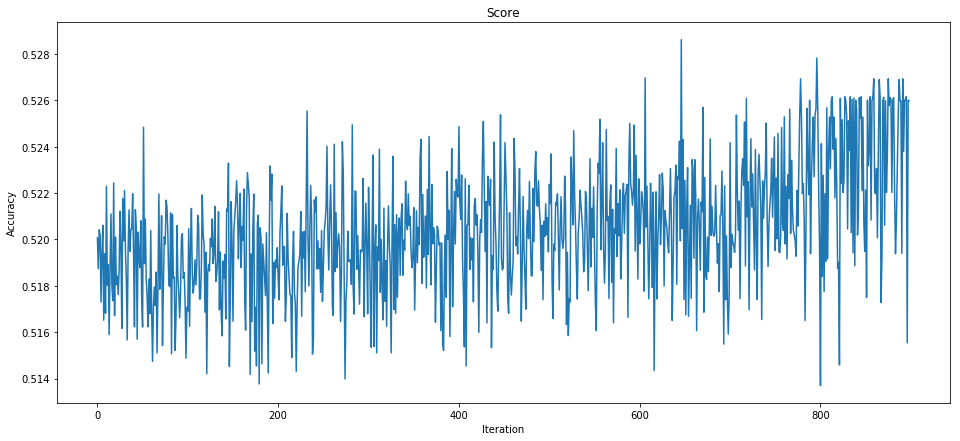

In [40]:
viz(SCORES, name='Score', xlabel='Iteration', ylabel='Accuracy')

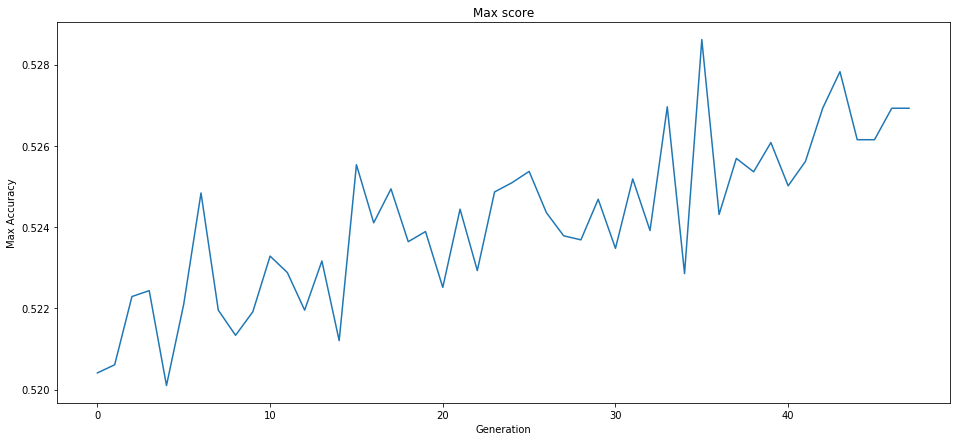

In [43]:
viz(list(map(lambda v: v['max'], STATS)), name='Max score', xlabel='Generation', ylabel='Max Accuracy')

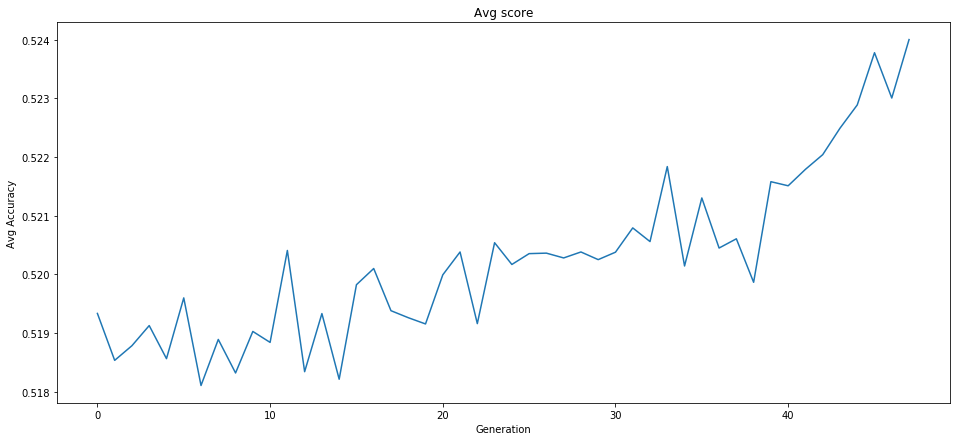

In [44]:
viz(list(map(lambda v: v['avg'], STATS)), name='Avg score', xlabel='Generation', ylabel='Avg Accuracy')